# EpiInfer-CONTACT: Complete Implementation (Algorithms 1–5)

In [1]:
import numpy as np
import pandas as pd
import math
import random
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import gdown

Complete implementation of EpiInfer-CONTACT from the research paper:
| # | Name | Purpose |
|--:|------|----------|
| 1 | `CONTACTINFER-CORE` | One-day infection inference loop using contact tracing |
| 2 | `predict_exposures` | Predicts who becomes newly exposed given contacts |
| 3 | `find_prob_exposure` | Computes exposure probability per susceptible |
| 4 | `simulate_epiinfer_core` | Aggregate meeting-distribution version (uses mean contacts) |
| 5 | `continuous_calibrate` | Searches (p₁, p₂) to minimize RMSE on training data |

# UTILITY FUNCTIONS

In [2]:
# ========== UTILITY FUNCTIONS ==========

def adjacency_from_pairs(contacts_per_day, population):
    """Convert contact pairs into adjacency dictionary for each day."""
    adj = {}
    for d, pairs in contacts_per_day.items():
        dayadj = {p: set() for p in population}
        for a, b in pairs:
            dayadj[a].add(b)
            dayadj[b].add(a)
        adj[d] = dayadj
    return adj

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return math.sqrt(mean_squared_error(y_true, y_pred))

# ========== ALGORITHM 3: FINDPROB ==========

def find_prob_exposure(adj_per_day, exposed_set, person, p1, day):
    """
    Algorithm 3 from paper: Calculate probability that susceptible person
    becomes exposed on given day based on contacts with exposed individuals.

    Returns: 1 - (1 - p1)^countEncounters
    """
    if day not in adj_per_day:
        return 0.0

    # Count encounters with exposed individuals
    encounters = len(adj_per_day[day].get(person, set()) & exposed_set)

    # Probability of NOT getting infected from all encounters
    return 1 - (1 - p1)**encounters if encounters > 0 else 0.0

# ========== ALGORITHM 2: PREDICT ==========

def predict_exposures(adj_per_day, BelExp_d, BelSusc_d, p1, day):
    """
    Algorithm 2 from paper: Predict who becomes newly exposed given contacts.

    Strategy:
    1. Calculate exposure probability for each susceptible
    2. Compute expected number N of new exposures
    3. Select top N individuals with highest exposure probability

    Returns: (set of newly exposed, dict of raw probabilities)
    """
    # Calculate exposure probability for each susceptible
    raw_probs = {s: find_prob_exposure(adj_per_day, BelExp_d, s, p1, day)
                 for s in BelSusc_d}

    # Expected number of newly exposed
    N = int(round(sum(raw_probs.values())))

    if N <= 0:
        return set(), raw_probs

    # Select top N individuals by probability
    sorted_susc = sorted(raw_probs.items(), key=lambda kv: -kv[1])
    chosen = {pid for pid, _ in sorted_susc[:N]}

    return chosen, raw_probs

# Main Class

In [3]:
class EpiInferContact:
    """
    Main class implementing all EpiInfer-CONTACT algorithms.
    Supports both contact-tracing and meeting-distribution approaches.

    CHANGES:
    1. Class renamed from EpiInferCore to EpiInferContact
    2. Added duration_recovered parameter
    3. Smart initialization: exposed count = infected/p2, assigned by contact frequency
    4. Susceptible now excludes Recovered individuals
    """

    def __init__(self, population, contacts_per_day=None):
        """
        Initialize with population and optional contact tracing data.

        Parameters:
        - population: list of individual IDs
        - contacts_per_day: dict {day: [(person_a, person_b), ...]}
        """
        self.population = list(population)
        self.pop_set = set(population)
        self.contacts_adj = adjacency_from_pairs(contacts_per_day, population) if contacts_per_day else {}

    def _count_total_contacts(self, person):
        """Helper: Count total contacts for a person across all available days."""
        total = 0
        for day_adj in self.contacts_adj.values():
            total += len(day_adj.get(person, set()))
        return total

    def _initialize_exposed_from_infected(self, initial_infected, p2):
        """
        CHANGE 3: Smart initialization of exposed population.

        Strategy:
        - Estimate exposed count = len(initial_infected) / p2
        - Assign exposure to individuals with most contacts (highest risk)

        Returns: set of initially exposed individuals
        """
        # Estimate number of exposed based on infected count
        estimated_exposed_count = int(round(len(initial_infected) / p2)) if p2 > 0 else 0

        if estimated_exposed_count == 0:
            return set()

        # Exclude already infected from consideration
        candidates = self.pop_set - initial_infected

        if not candidates:
            return set()

        # Count total contacts for each candidate
        contact_counts = {person: self._count_total_contacts(person) for person in candidates}

        # Sort by contact count (descending) and select top N
        sorted_candidates = sorted(contact_counts.items(), key=lambda x: -x[1])
        exposed_count = min(estimated_exposed_count, len(sorted_candidates))
        initial_exposed = {person for person, _ in sorted_candidates[:exposed_count]}

        return initial_exposed

    # ========== ALGORITHM 1: CONTACTINFER-CORE (UPDATED) ==========

    def contactinfer_run(self, p1, p2, inc, initial_infected,
                         initial_exposed=None,
                         max_day=20,
                         duration_infected=7,
                         duration_recovered=14,
                         stochastic=True):
        """
        Algorithm 1 from paper: Main contact-tracing inference loop.

        UPDATES:
        1. Added duration_recovered parameter
        2. If initial_exposed not provided, compute it from initial_infected/p2
        3. Susceptible now excludes Recovered individuals

        Parameters:
        - p1: probability of exposure per contact with exposed person
        - p2: probability exposed person becomes infected
        - inc: incubation period (days)
        - initial_infected: set of initially infected individuals
        - initial_exposed: set of initially exposed (if None, computed from infected/p2)
        - max_day: number of days to simulate
        - duration_infected: how long someone stays infected
        - duration_recovered: how long someone stays recovered (immune)
        - stochastic: if True, use probabilistic sampling; if False, use expected values

        Returns: DataFrame with daily statistics
        """
        # CHANGE 3: Initialize exposed from infected if not provided
        if initial_exposed is None:
            initial_exposed = self._initialize_exposed_from_infected(initial_infected, p2)
            print(f"Initialized {len(initial_exposed)} exposed individuals based on {len(initial_infected)} infected (ratio: 1/{p2:.2f})")

        # Initialize tracking dictionaries
        self.BelNewExp = defaultdict(set)
        self.BelNewInf = defaultdict(set)
        self.BelNewRec = defaultdict(set)  # Track new recoveries
        self.BelExp = defaultdict(set)
        self.BelInf = defaultdict(set)
        self.BelRec = defaultdict(set)  # Track recovered individuals

        # Day 1 initialization
        self.BelNewExp[1] = set(initial_exposed)
        self.BelNewInf[1] = set(initial_infected)
        self.BelExp[1] = set(initial_exposed)
        self.BelInf[1] = set(initial_infected)
        self.BelRec[1] = set()

        records = []

        for d in range(1, max_day + 1):
            # Current state
            exp_d = self.BelExp[d]
            inf_d = self.BelInf[d]
            rec_d = self.BelRec[d]

            # CHANGE 4: Susceptible = Everyone - (Exposed ∪ Infected ∪ Recovered)
            susc_d = self.pop_set - (exp_d | inf_d | rec_d)

            # Algorithm 2: Predict new exposures
            new_exp, raw_probs = predict_exposures(self.contacts_adj, exp_d, susc_d, p1, d)
            self.BelNewExp[d + 1] = new_exp
            self.BelExp[d + 1] = exp_d | new_exp

            # Algorithm 1 Line 8: Infections from exposures inc days ago
            src_day = d + 1 - inc
            new_inf = set()

            if src_day >= 1:
                old_exp = self.BelNewExp[src_day]

                if stochastic:
                    # Each individual becomes infected with probability p2
                    new_inf = {e for e in old_exp if random.random() < p2}
                else:
                    # Deterministic approximation using expected value
                    k = int(round(p2 * len(old_exp)))
                    if k > 0 and len(old_exp) > 0:
                        new_inf = set(random.sample(list(old_exp), min(k, len(old_exp))))

            self.BelNewInf[d + 1] = new_inf

            # Active infections = all infections within duration window
            window_inf = range(max(1, d + 1 - duration_infected + 1), d + 2)
            active_inf = set().union(*[self.BelNewInf[t] for t in window_inf])
            self.BelInf[d + 1] = active_inf

            # NEW: Track recoveries (people who left infected state)
            recovery_day = d + 1 - duration_infected
            if recovery_day >= 1:
                new_rec = self.BelNewInf[recovery_day]
                self.BelNewRec[d + 1] = new_rec
            else:
                self.BelNewRec[d + 1] = set()

            # Active recovered = all recoveries within duration_recovered window
            window_rec = range(max(1, d + 1 - duration_recovered + 1), d + 2)
            active_rec = set().union(*[self.BelNewRec[t] for t in window_rec])
            self.BelRec[d + 1] = active_rec

            records.append({
                "day": d,
                "new_exposed": len(new_exp),
                "new_infected": len(new_inf),
                "new_recovered": len(self.BelNewRec[d + 1]),
                "total_exposed": len(self.BelExp[d + 1]),
                "total_infected": len(self.BelInf[d + 1]),
                "total_recovered": len(self.BelRec[d + 1]),
                "total_susceptible": len(susc_d),
                "expected_new_exposed": int(round(sum(raw_probs.values())))
            })

        return pd.DataFrame(records)

    # ========== ALGORITHM 4: EPIINFER-CORE ==========

    def simulate_epiinfer_core(self, p1, p2, inc, NewInf_hist, asymp_hist,
                              recovered_hist, mean_meetings, max_day):
        """
        Algorithm 4 from paper: Meeting-distribution based inference.

        Uses Equations 1-5 from the paper.

        Parameters:
        - p1: exposure probability per contact
        - p2: probability exposed becomes infected
        - inc: incubation period
        - NewInf_hist: dict {day: count} of initial infections
        - asymp_hist: dict {day: count} of asymptomatic population
        - recovered_hist: dict {day: count} of recovered population
        - mean_meetings: dict {day: average_contacts}
        - max_day: number of days to predict

        Returns: dict {day: predicted_new_infections}
        """
        NewInf = defaultdict(int, NewInf_hist)
        asymp = defaultdict(int, asymp_hist)
        recovered = defaultdict(int, recovered_hist)
        preds = {}

        for d in range(1, max_day + 1):
            t = d - inc

            # Before incubation period ends, use known values
            if t < 1:
                preds[d] = NewInf.get(d, 0)
                continue

            # === Equation (1): Probability already exposed at time t ===
            numerator = sum([NewInf.get(d - i, 0) for i in range(1, inc + 1)])
            denominator = p2 * max(1, asymp[t])
            palreadyexp = min(numerator / denominator, 1.0) if denominator > 0 else 0

            # === Equation (2): Probability of new exposure ===
            mean_contacts = mean_meetings.get(t, 0)
            p_newexposed = 1 - (1 - p1) ** (mean_contacts * palreadyexp)

            # === Equation (3): asymptomaticNotEx ===
            already_exposed_count = numerator / p2 if p2 > 0 else 0
            asymptomaticNotEx = (asymp[t]
                                - already_exposed_count
                                - recovered.get(t, 0))
            asymptomaticNotEx = max(0, asymptomaticNotEx)

            # === Equation (4): Expected newly exposed ===
            NewExposed = asymptomaticNotEx * p_newexposed

            # === Equation (5): Predicted new infections ===
            preds[d] = int(round(p2 * NewExposed))
            NewInf[d] = preds[d]

        return preds

    # ========== ALGORITHM 5: CONTINUOUSCALIBRATE ==========

    def continuous_calibrate(self, observed_newinf, inc, mean_meetings,
                           asymp_hist=None, recovered_hist=None,
                           p2_values=None, training_window=5, verbose=False):
        """
        Algorithm 5 from paper: Find optimal p1 and p2 parameters.

        Parameters:
        - observed_newinf: dict {day: count} of observed infections
        - inc: incubation period
        - mean_meetings: dict {day: average_contacts}
        - asymp_hist: dict {day: count} of asymptomatic population
        - recovered_hist: dict {day: count} of recovered population
        - p2_values: list of p2 values to test
        - training_window: number of recent days to use for RMSE
        - verbose: print progress

        Returns: dict with keys 'p1', 'p2', 'rmse'
        """
        if p2_values is None:
            p2_values = [round(x, 2) for x in np.arange(0.1, 1.01, 0.1)]

        # Setup default histories if not provided
        days = sorted(observed_newinf.keys())
        if asymp_hist is None:
            asymp_hist = {d: len(self.population) for d in days}
        if recovered_hist is None:
            recovered_hist = {d: 0 for d in days}

        # Training window
        end_day = max(days)
        start_day = max(1, end_day - training_window + 1)
        obs = [observed_newinf.get(d, 0) for d in range(start_day, end_day + 1)]

        best = {"p1": None, "p2": None, "rmse": float("inf")}

        # Grid search over p2
        for p2 in p2_values:
            lo, hi = 0.0, 1.0

            # Binary search for p1 (up to 15 iterations)
            for iteration in range(15):
                mid = (lo + hi) / 2.0

                # Run simulation with current parameters
                preds = self.simulate_epiinfer_core(
                    mid, p2, inc,
                    {1: observed_newinf.get(1, 0)},
                    asymp_hist,
                    recovered_hist,
                    mean_meetings,
                    end_day
                )

                # Calculate RMSE on training window
                pred = [preds.get(d, 0) for d in range(start_day, end_day + 1)]
                error = rmse(obs, pred)

                # Update best parameters
                if error < best["rmse"]:
                    best.update({"p1": mid, "p2": p2, "rmse": error})

                # Binary search update
                if np.mean(pred) > np.mean(obs):
                    hi = mid
                else:
                    lo = mid

            if verbose:
                print(f"p2={p2:.1f} → best_p1≈{best['p1']:.3f}, RMSE={best['rmse']:.3f}")

        return best

### Download input files

In [4]:
gdown.download('https://drive.google.com/file/d/1rV60qkWgC3hS1F7061mAEyUz8xEQyI4d/view?usp=sharing', fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1rV60qkWgC3hS1F7061mAEyUz8xEQyI4d
To: /content/states_total.csv
100%|██████████| 914/914 [00:00<00:00, 1.90MB/s]


'states_total.csv'

In [5]:
gdown.download('https://docs.google.com/spreadsheets/d/12SxTHwdj1w7PaphOweNh58cSewkp8T9l/edit?usp=sharing&ouid=107283854447072019551&rtpof=true&sd=true', fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=12SxTHwdj1w7PaphOweNh58cSewkp8T9l
To: /content/daily_contacts_multisheet.xlsx
100%|██████████| 27.8M/27.8M [00:00<00:00, 70.3MB/s]


'daily_contacts_multisheet.xlsx'

# ========== LOAD DATA ==========

In [6]:
def load_states_data(filepath='states_total.csv'):
    """Load the SEIR states data."""
    df = pd.read_csv(filepath)
    return df

def load_contact_data(filepath='daily_contacts_multisheet.xlsx', max_days=50):
    """
    Load contact data from Excel file with multiple sheets.
    Returns: dict {day: [(person_a, person_b), ...]}
    """
    contacts_per_day = {}

    for day in range(1, max_days + 1):
        sheet_name = f'Day_{day}'
        try:
            df = pd.read_excel(filepath, sheet_name=sheet_name)

            # Extract contact pairs from columns B (Person_A_ID) and D (Person_B_ID)
            # Assuming columns are indexed as: A=0, B=1, C=2, D=3
            if 'Person_A_ID' in df.columns and 'Person_B_ID' in df.columns:
                person_a = df['Person_A_ID'].dropna()
                person_b = df['Person_B_ID'].dropna()
            else:
                # Fallback to column indices if headers don't match
                person_a = df.iloc[:, 1].dropna()  # Column B (index 1)
                person_b = df.iloc[:, 3].dropna()  # Column D (index 3)

            # Create contact pairs
            pairs = list(zip(person_a, person_b))
            contacts_per_day[day] = pairs

            print(f"Loaded {len(pairs)} contacts for Day {day}")

        except Exception as e:
            print(f"Warning: Could not load Day_{day}: {e}")
            contacts_per_day[day] = []

    return contacts_per_day

def extract_population(contacts_per_day):
    """Extract unique population IDs from contact data."""
    population = set()
    for day, pairs in contacts_per_day.items():
        for a, b in pairs:
            population.add(a)
            population.add(b)
    return list(population)

def calculate_mean_meetings(contacts_per_day, population):
    """Calculate mean number of meetings per person per day."""
    mean_meetings = {}

    for day, pairs in contacts_per_day.items():
        # Count contacts per person
        contact_count = defaultdict(int)
        for a, b in pairs:
            contact_count[a] += 1
            contact_count[b] += 1

        # Calculate mean
        if len(population) > 0:
            total_contacts = sum(contact_count.values())
            mean_meetings[day] = total_contacts / len(population)
        else:
            mean_meetings[day] = 0

    return mean_meetings

def grid_search_parameters(model, states_df, population, contacts_per_day,
                          initial_infected, initial_exposed, max_day=50):
    """
    Perform grid search to find optimal parameters.
    Tests multiple combinations of p1, p2, inc, and durations.
    """
    print("\n" + "="*60)
    print("GRID SEARCH FOR OPTIMAL PARAMETERS")
    print("="*60)

    # Parameter ranges focused on better values based on original good results
    # p1_values = [0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    # p2_values = [0.3, 0.4, 0.5, 0.6, 0.7]
    # inc_values = [4, 5, 6]
    # duration_infected_values = [8, 10, 12, 14]

    p1_values = [0.01, 0.02, 0.03, 0.05, 0.08, 0.10]
    p2_values = [0.3, 0.4, 0.5, 0.6, 0.7]
    inc_values = [3, 4, 5, 6]
    duration_infected_values = [7, 10, 14]

    best_rmse = float('inf')
    best_config = None
    results_list = []

    total_tests = len(p1_values) * len(p2_values) * len(inc_values) * len(duration_infected_values)
    test_num = 0

    for p1 in p1_values:
        for p2 in p2_values:
            for inc in inc_values:
                for dur_inf in duration_infected_values:
                    test_num += 1

                    try:
                        # Run simulation
                        results_df = model.contactinfer_run(
                            p1=p1,
                            p2=p2,
                            inc=inc,
                            initial_infected=initial_infected,
                            initial_exposed=initial_exposed,
                            max_day=max_day,
                            duration_infected=dur_inf,
                            duration_recovered=100,
                            stochastic=False  # Use deterministic for fair comparison
                        )

                        # Calculate RMSE for infected counts (most important!)
                        actual_infected = states_df['I'].values[:len(results_df)]
                        predicted_infected = results_df['total_infected'].values
                        rmse_infected = math.sqrt(np.mean((actual_infected - predicted_infected) ** 2))

                        # Calculate RMSE for exposed counts
                        actual_exposed = states_df['E'].values[:len(results_df)]
                        predicted_exposed = results_df['total_exposed'].values
                        rmse_exposed = math.sqrt(np.mean((actual_exposed - predicted_exposed) ** 2))

                        # Peak alignment is critical
                        actual_peak_day = states_df['I'].idxmax()
                        pred_peak_day = results_df['total_infected'].idxmax()
                        peak_diff = abs(actual_peak_day - pred_peak_day)

                        # Peak magnitude alignment
                        actual_peak_val = states_df['I'].max()
                        pred_peak_val = results_df['total_infected'].max()
                        peak_magnitude_error = abs(actual_peak_val - pred_peak_val)
                        peak_ratio = pred_peak_val / actual_peak_val if actual_peak_val > 0 else 1.0

                        # Combined metric prioritizing infected RMSE and peak timing
                        # Penalize heavily if peak is off by more than 3 days
                        peak_penalty = 100 * max(0, peak_diff - 3)
                        rmse_val = rmse_infected + peak_penalty

                        results_list.append({
                            'p1': p1,
                            'p2': p2,
                            'inc': inc,
                            'dur_inf': dur_inf,
                            'rmse': rmse_val,
                            'rmse_infected': rmse_infected,
                            'rmse_exposed': rmse_exposed,
                            'peak_diff': peak_diff,
                            'peak_ratio': peak_ratio,
                            'peak_magnitude_error': peak_magnitude_error
                        })

                        if rmse_val < best_rmse:
                            best_rmse = rmse_val
                            best_config = {
                                'p1': p1,
                                'p2': p2,
                                'inc': inc,
                                'duration_infected': dur_inf,
                                'rmse': rmse_val,
                                'rmse_infected': rmse_infected,
                                'rmse_exposed': rmse_exposed,
                                'peak_diff': peak_diff,
                                'peak_ratio': peak_ratio,
                                'peak_magnitude_error': peak_magnitude_error
                            }
                            print(f"[{test_num}/{total_tests}] ⭐ New best! p1={p1:.3f}, p2={p2:.1f}, inc={inc}, dur={dur_inf}")
                            print(f"    → RMSE(I)={rmse_infected:.1f}, peak_day_diff={peak_diff}, peak_ratio={peak_ratio:.2f}")

                    except Exception as e:
                        print(f"[{test_num}/{total_tests}] Failed: {e}")
                        continue

    print("\n" + "="*60)
    print("GRID SEARCH COMPLETE")
    print("="*60)
    print(f"\n🏆 Best Configuration:")
    print(f"  p1 (exposure prob per contact): {best_config['p1']:.4f}")
    print(f"  p2 (exposed → infected prob): {best_config['p2']:.2f}")
    print(f"  inc (incubation period): {best_config['inc']} days")
    print(f"  duration_infected: {best_config['duration_infected']} days")
    print(f"\n📊 Performance Metrics:")
    print(f"  RMSE (Infected): {best_config['rmse_infected']:.2f}")
    print(f"  RMSE (Exposed): {best_config['rmse_exposed']:.2f}")
    print(f"  Peak day difference: {best_config['peak_diff']} days")
    print(f"  Peak magnitude ratio: {best_config['peak_ratio']:.2f}")
    print(f"  Peak magnitude error: {best_config['peak_magnitude_error']:.0f} people")

    # Save results to CSV
    results_grid_df = pd.DataFrame(results_list)
    results_grid_df = results_grid_df.sort_values('rmse')
    results_grid_df.to_csv('grid_search_results.csv', index=False)
    print(f"\n💾 Saved grid search results to 'grid_search_results.csv'")
    print(f"\n📋 Top 10 configurations:")
    print(results_grid_df[['p1', 'p2', 'inc', 'dur_inf', 'rmse_infected', 'peak_diff', 'peak_ratio']].head(10).to_string(index=False))

    return best_config

# ========== MAIN ANALYSIS ==========

In [7]:
def main():
    """Main analysis pipeline."""

    print("=" * 60)
    print("EpiInfer-CONTACT Data Application")
    print("=" * 60)

    # 1. Load states data
    print("\n1. Loading SEIR states data...")
    states_df = load_states_data('states_total.csv')
    print(f"Loaded {len(states_df)} days of data")
    print(f"Population size: {states_df.iloc[0][['S', 'E', 'I', 'R']].sum()}")

    # 2. Load contact data
    print("\n2. Loading contact tracing data...")
    contacts_per_day = load_contact_data('daily_contacts_multisheet.xlsx', max_days=50)

    # 3. Extract population
    print("\n3. Extracting population...")
    population = extract_population(contacts_per_day)
    print(f"Unique individuals in contact data: {len(population)}")

    # 4. Calculate mean meetings
    print("\n4. Calculating mean meetings per day...")
    mean_meetings = calculate_mean_meetings(contacts_per_day, population)
    print(f"Average meetings across all days: {np.mean(list(mean_meetings.values())):.2f}")

    # 5. Initialize EpiInfer-CONTACT model
    print("\n5. Initializing EpiInfer-CONTACT model...")

    model = EpiInferContact(population, contacts_per_day)

    # 6. Set up initial conditions from states data
    print("\n6. Setting up initial conditions...")
    day0 = states_df[states_df['day'] == 0].iloc[0]

    # Use actual exposed count from data
    initial_exposed_count = int(day0['E'])
    initial_infected_count = int(day0['I']) if day0['I'] > 0 else 1

    # Randomly select initial individuals from population
    # First select infected
    initial_infected = set(random.sample(population, min(initial_infected_count, len(population))))

    # Then select exposed (excluding infected)
    remaining_pop = list(set(population) - initial_infected)
    initial_exposed = set(random.sample(remaining_pop, min(initial_exposed_count, len(remaining_pop))))

    print(f"Initial exposed: {len(initial_exposed)}")
    print(f"Initial infected: {len(initial_infected)}")

    max_day = 50

    # NEW: Perform grid search to find optimal parameters
    print("\n=== PERFORMING GRID SEARCH FOR OPTIMAL PARAMETERS ===")
    best_config = grid_search_parameters(
        model, states_df, population, contacts_per_day,
        initial_infected, initial_exposed, max_day=50
    )

    # Use best configuration from grid search
    p1 = best_config['p1']
    p2 = best_config['p2']
    inc = best_config['inc']
    duration_infected = best_config['duration_infected']
    duration_recovered = 100

    # 7. Run CONTACTINFER-CORE algorithm with optimized parameters
    print("\n7. Running CONTACTINFER-CORE algorithm with optimized parameters...")

    print(f"Using parameters: p1={p1:.4f}, p2={p2:.2f}, inc={inc}, dur_inf={duration_infected}")

    results_df = model.contactinfer_run(
        p1=p1,
        p2=p2,
        inc=inc,
        initial_infected=initial_infected,
        initial_exposed=initial_exposed,  # Use actual initial exposed
        max_day=max_day,
        duration_infected=duration_infected,
        duration_recovered=duration_recovered,
        stochastic=True
    )

    print("\nSimulation Results (first 10 days):")
    print(results_df.head(10))

    # 8. Visualize results
    print("\n8. Generating visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Comparison with actual data
    ax1 = axes[0, 0]
    ax1.plot(states_df['day'], states_df['I'], 'o-', label='Actual Infected', linewidth=2)
    ax1.plot(results_df['day'], results_df['total_infected'], 's-', label='Predicted Infected', linewidth=2)
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Count')
    ax1.set_title('Infected: Actual vs Predicted')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: All compartments - Actual
    ax2 = axes[0, 1]
    ax2.plot(states_df['day'], states_df['S'], label='Susceptible')
    ax2.plot(states_df['day'], states_df['E'], label='Exposed')
    ax2.plot(states_df['day'], states_df['I'], label='Infected')
    ax2.plot(states_df['day'], states_df['R'], label='Recovered')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Count')
    ax2.set_title('Actual SEIR Compartments')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: All compartments - Predicted
    ax3 = axes[1, 0]
    ax3.plot(results_df['day'], results_df['total_susceptible'], label='Susceptible')
    ax3.plot(results_df['day'], results_df['total_exposed'], label='Exposed')
    ax3.plot(results_df['day'], results_df['total_infected'], label='Infected')
    ax3.plot(results_df['day'], results_df['total_recovered'], label='Recovered')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Count')
    ax3.set_title('Predicted SEIR Compartments')
    ax3.legend()
    ax3.grid(True)

    # Plot 4: New cases per day
    ax4 = axes[1, 1]
    ax4.bar(results_df['day'], results_df['new_infected'], alpha=0.7, label='New Infected')
    ax4.bar(results_df['day'], results_df['new_exposed'], alpha=0.7, label='New Exposed')
    ax4.set_xlabel('Day')
    ax4.set_ylabel('Count')
    ax4.set_title('Daily New Cases')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig('epiinfer_results.png', dpi=300, bbox_inches='tight')
    print("Saved visualization to 'epiinfer_results.png'")
    plt.show()

    # 9. Calculate performance metrics
    print("\n9. Performance Metrics:")

    # Compare infected counts
    actual_infected = states_df['I'].values[:len(results_df)]
    predicted_infected = results_df['total_infected'].values

    rmse_infected = math.sqrt(np.mean((actual_infected - predicted_infected) ** 2))
    mae_infected = np.mean(np.abs(actual_infected - predicted_infected))

    print(f"RMSE (Infected): {rmse_infected:.2f}")
    print(f"MAE (Infected): {mae_infected:.2f}")

    # 10. Skip continuous_calibrate - it's designed for meeting-distribution, not contact-tracing
    # The grid search already found optimal parameters
    print("\n10. Skipping continuous_calibrate (designed for Algorithm 4, not Algorithm 1)")
    print(f"Using grid-search optimized parameters from earlier:")
    print(f"  p1 (exposure prob): {p1:.4f}")
    print(f"  p2 (infection prob): {p2:.2f}")
    print(f"  inc (incubation): {inc} days")
    print(f"  duration_infected: {duration_infected} days")
    print(f"  Grid search RMSE: {best_config['rmse']:.2f}")
    print(f"    - Infected RMSE: {best_config['rmse_infected']:.2f}")
    print(f"    - Exposed RMSE: {best_config['rmse_exposed']:.2f}")
    print(f"    - Peak day difference: {best_config['peak_diff']} days")
    print(f"    - Peak magnitude ratio: {best_config['peak_ratio']:.2f}")
    print(f"    - Peak magnitude error: {best_config['peak_magnitude_error']:.0f} people")

    # 11. Save results
    print("\n11. Saving results...")
    results_df.to_csv('contactinfer_results.csv', index=False)
    print("Saved results to 'contactinfer_results.csv'")

    print("\n" + "=" * 60)
    print("Analysis Complete!")
    print("=" * 60)

EpiInfer-CONTACT Data Application

1. Loading SEIR states data...
Loaded 51 days of data
Population size: 2000

2. Loading contact tracing data...
Loaded 23403 contacts for Day 1
Loaded 23559 contacts for Day 2
Loaded 23459 contacts for Day 3
Loaded 23224 contacts for Day 4
Loaded 23064 contacts for Day 5
Loaded 22553 contacts for Day 6
Loaded 21988 contacts for Day 7
Loaded 19935 contacts for Day 8
Loaded 15889 contacts for Day 9
Loaded 10809 contacts for Day 10
Loaded 7936 contacts for Day 11
Loaded 7293 contacts for Day 12
Loaded 8288 contacts for Day 13
Loaded 11419 contacts for Day 14
Loaded 15383 contacts for Day 15
Loaded 17750 contacts for Day 16
Loaded 18629 contacts for Day 17
Loaded 19738 contacts for Day 18
Loaded 21123 contacts for Day 19
Loaded 21792 contacts for Day 20
Loaded 22651 contacts for Day 21
Loaded 23134 contacts for Day 22
Loaded 23163 contacts for Day 23
Loaded 23242 contacts for Day 24
Loaded 23121 contacts for Day 25
Loaded 23597 contacts for Day 26
Loaded 

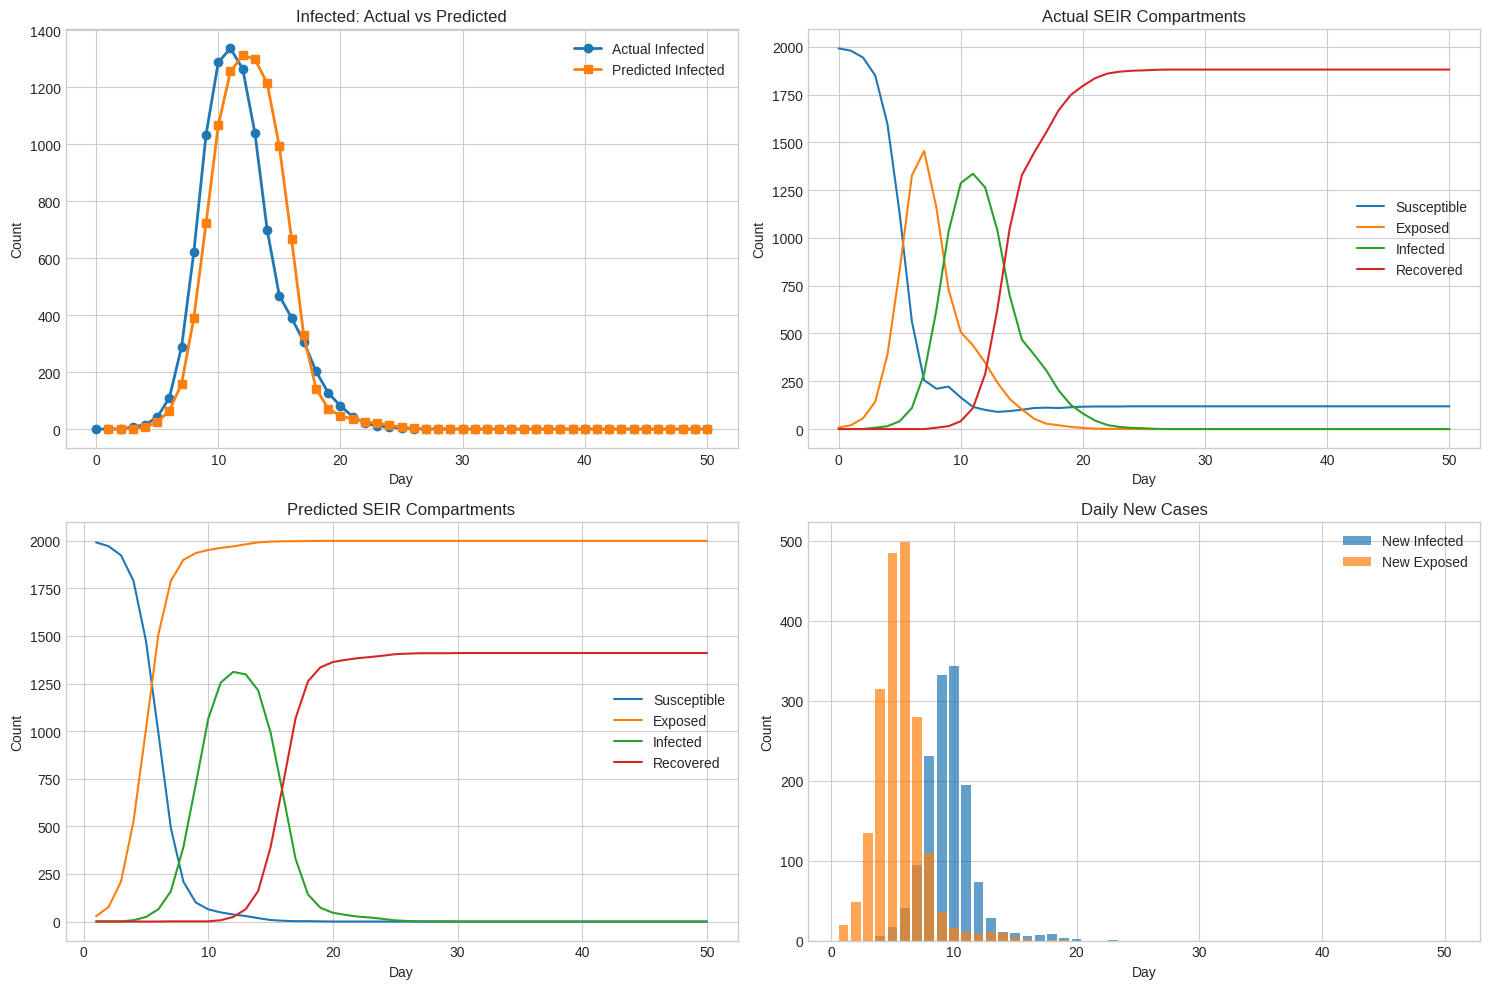


9. Performance Metrics:
RMSE (Infected): 69.22
MAE (Infected): 31.68

10. Skipping continuous_calibrate (designed for Algorithm 4, not Algorithm 1)
Using grid-search optimized parameters from earlier:
  p1 (exposure prob): 0.0800
  p2 (infection prob): 0.70
  inc (incubation): 4 days
  duration_infected: 7 days
  Grid search RMSE: 70.07
    - Infected RMSE: 70.07
    - Exposed RMSE: 1766.54
    - Peak day difference: 0 days
    - Peak magnitude ratio: 0.98
    - Peak magnitude error: 26 people

11. Saving results...
Saved results to 'contactinfer_results.csv'

Analysis Complete!


In [8]:
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    main()